# SET UP

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from os import listdir
from os.path import isfile, join
import random
import shutil
from matplotlib.image import imread
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

from tensorflow.keras.utils import Sequence
import time
import seaborn as sns
import DCGAN as gan
import json

In [4]:
IMG_DIR = './PokemonData'
dirs = os.listdir(IMG_DIR)
print(dirs[:5])

['Abra', 'Aerodactyl', 'Alakazam', 'Alolan Sandslash', 'Arbok']


# DATA EXTRACTOR

In [5]:
def files_info_extractor(path):
    dir_list = os.listdir(path)
    y = []
    X = []
    for i in range(len(dir_list)):
        files = os.listdir(os.path.join(path,dir_list[i]))
        for j in range(len(files)):
            X.append([files[j],dir_list[i]])
    return X

In [6]:
x = files_info_extractor(IMG_DIR)
X = pd.DataFrame(x,columns=["file","label"])
X

,file,label
0,0282b2f3a22745f1a436054ea15a0ae5.jpg,Abra
1,06b9eec4827d4d49b1b4c284308708df.jpg,Abra
2,10a9f06ec6524c66b779ea80354f8519.jpg,Abra
3,1788abb8b51f48509cfac8067bd99e14.jpg,Abra
4,28cfad92ad934d1f9b579cbff4b5d012.jpg,Abra
...,...,...
6820,dd387067380e4d1f8672c30d4b567fac.jpg,Zubat
6821,e1997a18e61641a4b0e701f6bc4c70f4.jpg,Zubat
6822,e6cba9a117d64d849fcc389e04e92e11.jpg,Zubat
6823,f8788465c10a4ab8bb0aeb992ec060ce.jpg,Zubat


In [7]:
def create_train_val_test_folder():
    os.system("mkdir train")
    os.system("mkdir test")
    os.system("mkdir val")
def clean_images():
    os.system("rm -r train/* test/* val/*")
    os.system("find train/ -name '*.*' -type f -delete")
    os.system("find val/ -name '*.*' -type f -delete")
    os.system("find test/ -name '*.*' -type f -delete")
def data_extractor(class_pct,train_pct,val_pct,test_pct):
    
    sub_classes = random.sample(dirs,int(len(dirs)*class_pct))
    for cla in sub_classes:
        os.system('mkdir "train/'+cla+'"')
        os.system('mkdir "test/'+cla+'"')
        os.system('mkdir "val/'+cla+'"')
        os.system("find train/"+cla+" -name '*.*' -type f -delete")
        os.system("find val/"+cla+" -name '*.*' -type f -delete")
        os.system("find test/"+cla+" -name '*.*' -type f -delete")
        temp_files = os.listdir(os.path.join(IMG_DIR,cla))
        files = [f for f in temp_files if isfile(os.path.join(IMG_DIR, cla,f))]
        train_files = random.sample(files,int(len(files)*(train_pct+val_pct+test_pct)))
        val_files = random.sample(train_files,int(len(files)*(val_pct+test_pct)))
        test_files = random.sample(val_files,int(len(files)*test_pct))
        train_files = [x for x in train_files if x not in val_files]
        val_files = [x for x in val_files if x not in test_files]
        for file in train_files:
            shutil.copy(os.path.join(IMG_DIR,cla,file), os.path.join('train',cla,file))
        for file in val_files:
            shutil.copy(os.path.join(IMG_DIR,cla,file), os.path.join('val',cla,file))
        for file in test_files:
            shutil.copy(os.path.join(IMG_DIR,cla,file), os.path.join('test',cla,file))

def data_extractor_gan(classes,train_pct, val_pct, test_pct):
    for cla in classes:
        os.system('mkdir "train/'+cla+'"')
        os.system('mkdir "test/'+cla+'"')
        os.system('mkdir "val/'+cla+'"')
        os.system("find train/"+cla+" -name '*.*' -type f -delete")
        os.system("find val/"+cla+" -name '*.*' -type f -delete")
        os.system("find test/"+cla+" -name '*.*' -type f -delete")
        os.system('mkdir "include_gan"')
        os.system('mkdir "include_gan/train/'+cla+'"')
        os.system('mkdir "include_gan/test/'+cla+'"')
        os.system('mkdir "include_gan/val/'+cla+'"')
        os.system("find include_gan/train/"+cla+" -name '*.*' -type f -delete")
        os.system("find include_gan/val/"+cla+" -name '*.*' -type f -delete")
        os.system("find include_gan/test/"+cla+" -name '*.*' -type f -delete")
        temp_files = os.listdir(os.path.join(IMG_DIR,cla))
        files = [f for f in temp_files if isfile(os.path.join(IMG_DIR, cla,f))]
        train_files = random.sample(files,int(len(files)*(train_pct+val_pct+test_pct)))
        val_files = random.sample(train_files,int(len(files)*(val_pct+test_pct)))
        test_files = random.sample(val_files,int(len(files)*test_pct))
        train_files = [x for x in train_files if x not in val_files]
        val_files = [x for x in val_files if x not in test_files]
        for file in train_files:
            shutil.copy(os.path.join(IMG_DIR,cla,file), os.path.join('include_gan','train',cla,file))
            shutil.copy(os.path.join(IMG_DIR,cla,file), os.path.join('train',cla,file))
        for file in val_files:
            shutil.copy(os.path.join(IMG_DIR,cla,file), os.path.join('include_gan','val',cla,file))
            shutil.copy(os.path.join(IMG_DIR,cla,file), os.path.join('val',cla,file))
        for file in test_files:
            shutil.copy(os.path.join(IMG_DIR,cla,file), os.path.join('include_gan','test',cla,file))
            shutil.copy(os.path.join(IMG_DIR,cla,file), os.path.join('test',cla,file))
        temp_files = os.listdir(os.path.join("savedData",cla))
        files = [f for f in temp_files if isfile(os.path.join("savedData", cla,f))]
        for file in files:
            shutil.copy(os.path.join("savedData",cla,file), os.path.join("include_gan",'train',cla,file))



In [39]:
gan_test_class = ["Arbok","Bulbasaur","Caterpie","Charizard","Cloyster","Cubone","Dewgong","Ditto","Dodrio","Dragonite","Dratini","Ekans"]

In [18]:
data_extractor_gan(class_names[:30],0.7,0.2,0.1)

In [16]:
create_train_val_test_folder()
#clean_images()
data_extractor(1,0.7,0.2,0.1)

# USE GAN MODEL TO GENERATE MORE IMAGES

C:\Users\15197\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


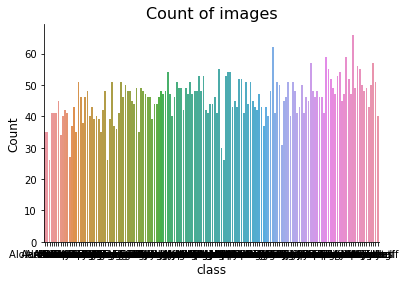

In [8]:
plt.title('Count of images', size=16)
sns.countplot(X["label"])
plt.ylabel('Count', size=12)
plt.xlabel('class', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
#plt.savefig("./plots/count_of_images_without_gan.png")
plt.show()

In [7]:
class_names = X["label"].unique()
max_num = X["label"].value_counts()

In [15]:
os.system("mkdir savedData")
for cla in class_names:
    os.system("mkdir savedData/"+cla)

In [9]:
class_names

array(['Abra', 'Aerodactyl', 'Alakazam', 'Alolan Sandslash', 'Arbok',
       'Arcanine', 'Articuno', 'Beedrill', 'Bellsprout', 'Blastoise',
       'Bulbasaur', 'Butterfree', 'Caterpie', 'Chansey', 'Charizard',
       'Charmander', 'Charmeleon', 'Clefable', 'Clefairy', 'Cloyster',
       'Cubone', 'Dewgong', 'Diglett', 'Ditto', 'Dodrio', 'Doduo',
       'Dragonair', 'Dragonite', 'Dratini', 'Drowzee', 'Dugtrio', 'Eevee',
       'Ekans', 'Electabuzz', 'Electrode', 'Exeggcute', 'Exeggutor',
       'Farfetchd', 'Fearow', 'Flareon', 'Gastly', 'Gengar', 'Geodude',
       'Gloom', 'Golbat', 'Goldeen', 'Golduck', 'Golem', 'Graveler',
       'Grimer', 'Growlithe', 'Gyarados', 'Haunter', 'Hitmonchan',
       'Hitmonlee', 'Horsea', 'Hypno', 'Ivysaur', 'Jigglypuff', 'Jolteon',
       'Jynx', 'Kabuto', 'Kabutops', 'Kadabra', 'Kakuna', 'Kangaskhan',
       'Kingler', 'Koffing', 'Krabby', 'Lapras', 'Lickitung', 'Machamp',
       'Machoke', 'Machop', 'Magikarp', 'Magmar', 'Magnemite', 'Magneton',
     

In [7]:
pokemon_class = ["Zapdos"]

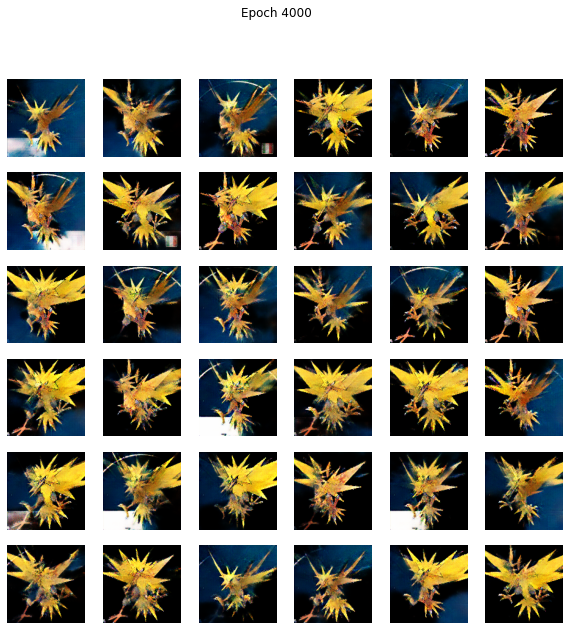

Lossy conversion from float32 to uint8. Range [0.0800018310546875, 254.95388793945312]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0800018310546875, 255.019287109375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.080108642578125, 254.9672393798828]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0800018310546875, 255.07708740234375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0800018310546875, 255.0684814453125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0800018310546875, 255.07122802734375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0800018310546875, 255.00881958007812].

In [9]:
import DCGAN as gan

for pokemon in pokemon_class:
    train_dataset = gan.create_dataset(os.path.join(IMG_DIR, pokemon) + "/*")
    save = str("./" + pokemon + "/")
    
    gan.train(train_dataset, epochs=4000, save_after=100, save_URL = save,num=36)

it means that the Generator found a certain mode in the data space tha tis able to continuously fool the Discriminator into thinking he sis seeing real samples instead of fake ones. In other words, it means that the Discriminator is unable to successfullly distinguish real and fake samples coming from that same data mode.

# TAKE A LOOK AT THE DATASET

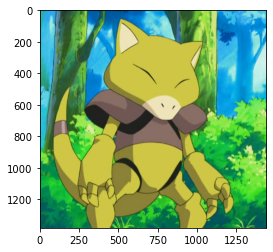

In [9]:
test_path = 'PokemonData/Abra/4e554e4a0f624656a7b1542b679b6157.jpg'
plt.imshow(imread(test_path))

# DATA AUGMATION USING ImageDataGenerator

C:\Users\15197\AppData\Roaming\Python\Python39\site-packages\keras_preprocessing\image\image_data_generator.py:337: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


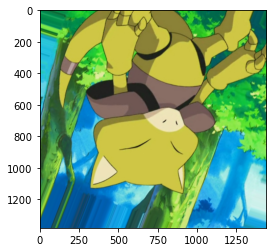

In [10]:
from keras.preprocessing.image import ImageDataGenerator

baselineDataGen = ImageDataGenerator()
rotateDataGen = ImageDataGenerator(rotation_range=40)
rescaleDataGen = ImageDataGenerator(rescale = 1./255)
zcaDataGen = ImageDataGenerator(zca_whitening=True)
zoomDataGen = ImageDataGenerator(zoom_range=0.5)
allDataGen = ImageDataGenerator(rotation_range=20,
                               rescale = 1./255,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.1,
                               zoom_range=0.1,
                               horizontal_flip=True,
                               vertical_flip = True,
                               fill_mode='nearest')

plt.imshow(baselineDataGen.random_transform(imread(test_path)))
plt.imshow(rotateDataGen.random_transform(imread(test_path)))
plt.imshow(rescaleDataGen.random_transform(imread(test_path)))
plt.imshow(zcaDataGen.random_transform(imread(test_path)))
plt.imshow(zoomDataGen.random_transform(imread(test_path)))
plt.imshow(allDataGen.random_transform(imread(test_path)))


In [11]:

image_shape = (256,256,3)


def generateDataFromDirectory(dg):
    train = dg.flow_from_directory('train/',target_size=image_shape[:2],
                                                color_mode='rgb',
                                                batch_size=100,
                                                class_mode='categorical')
    test = dg.flow_from_directory('test/',target_size=image_shape[:2],
                                                color_mode='rgb',
                                                batch_size=100,
                                                class_mode='categorical')
    val = dg.flow_from_directory('val/',target_size=image_shape[:2],
                                                color_mode='rgb',
                                                batch_size=15,
                                                class_mode='categorical')
    return train, test, val

def generateDataFromDirectory_gan(dg):
    train = dg.flow_from_directory('include_gan/train/',target_size=image_shape[:2],
                                                color_mode='rgb',
                                                batch_size=100,
                                                class_mode='categorical')
    test = dg.flow_from_directory('include_gan/test/',target_size=image_shape[:2],
                                                color_mode='rgb',
                                                batch_size=100,
                                                class_mode='categorical')
    val = dg.flow_from_directory('include_gan/val/',target_size=image_shape[:2],
                                                color_mode='rgb',
                                                batch_size=100,
                                                class_mode='categorical')
    return train, test, val

<h2> create callback_list for building model </h2>

In [12]:
os.system("mkdir saved_models")
filepath = "saved_models/weight-model-improvement-{epoch:02d}-{val_accuracy:.2f}-"+time.strftime("%Y%m%d-%H%M%S")+".h5"
#checkpoint = ModelCheckpoint(filepath, monitor="val_accuracy",verbose=1,save_best_only=True, model="max", save_weights_only=False)
#earlystopping = EarlyStopping(monitor="val_loss",patience=15,verbose=1,restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=10, verbose=0,
    mode='auto', min_delta=0.0001, cooldown=0, min_lr=0,
)
log_csv = CSVLogger("my_logs.csv",separator=',', append=False)
callback_list = [earlystopping,log_csv]
callback_list_with_reduction = [earlystopping,log_csv,reduce_lr]

NameError: name 'earlystopping' is not defined

<h2> define function to create baseline model which we use as a baseline to compare with other models </h2>

In [12]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, Activation, BatchNormalization, Lambda
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

ClassNum = 20
def build_baseline():
    model = Sequential()

    model.add(Conv2D(filters=64,kernel_size=(3,3),padding='same',input_shape=image_shape,activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))

    model.add(Conv2D(filters=128,kernel_size=(3,3),padding='same',input_shape=image_shape,activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    
    model.add(Conv2D(filters=256,kernel_size=(3,3),padding='same',input_shape=image_shape,activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))

    model.add(Flatten())

    model.add(Dense(256,activation='relu'))

    model.add(Dense(128,activation='relu'))

    model.add(Dense(ClassNum,activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

    return model

<h2> define function to compare the original dataset and dataset with gan included </h2>

In [16]:
def compared_with_without_gan():
    historys = []
    train, test, val = generateDataFromDirectory(allDataGen)
    gan_train, gan_test, gan_val = generateDataFromDirectory_gan(allDataGen)
    model = build_baseline()
    gan_model = build_baseline()
    history = model.fit(train, epochs=100, validation_data=val)
    gan_history = gan_model.fit(gan_train, epochs=100,validation_data=gan_val)
    historys.append(history)
    historys.append(gan_history)
    loss_history = pd.DataFrame(history.history)
    gan_loss_history = pd.DataFrame(gan_history.history)
    plt.plot(loss_history['val_accuracy'],label="original")
    plt.plot(gan_loss_history['val_accuracy'],label="gan")
    plt.legend()
    plt.savefig("./plots/compared_with_without_gan.png")
    plt.show()
    return historys

In [17]:
gan_historys = compared_with_without_gan()


Found 543 images belonging to 20 classes.
Found 71 images belonging to 20 classes.
Found 158 images belonging to 20 classes.
Found 1263 images belonging to 20 classes.
Found 71 images belonging to 20 classes.
Found 158 images belonging to 20 classes.
Epoch 1/100
37/37 [==============================] - 11s 275ms/step - loss: 2.9894 - accuracy: 0.0773 - val_loss: 2.7404 - val_accuracy: 0.1899
Epoch 2/100
37/37 [==============================] - 10s 269ms/step - loss: 2.4157 - accuracy: 0.2449 - val_loss: 1.9880 - val_accuracy: 0.3418
Epoch 3/100
37/37 [==============================] - 10s 269ms/step - loss: 1.7733 - accuracy: 0.4420 - val_loss: 1.6734 - val_accuracy: 0.4177
Epoch 4/100
37/37 [==============================] - 10s 269ms/step - loss: 1.3863 - accuracy: 0.4936 - val_loss: 1.4003 - val_accuracy: 0.4937
Epoch 5/100
37/37 [==============================] - 10s 268ms/step - loss: 1.2602 - accuracy: 0.5470 - val_loss: 1.2770 - val_accuracy: 0.5506
Epoch 6/100
37/37 [==========

KeyboardInterrupt: 

In [37]:
#json.dump(gan_historys[0].history,open("./historys/compared_generators_original",'w'))
#json.dump(gan_historys[1].history,open("./historys/compared_generators_gan",'w'))

<h2> define function to compare the accuracy of different generators </h2>

In [12]:
def compared_generators(gens,labels):
    historys = []
    for i in range(len(gens)):
        gen = gens[i]
        label = labels[i]
        train, test, val = generateDataFromDirectory(gen)
        model = build_baseline()
        history = model.fit(train, epochs=100, validation_data=val)
        historys.append(history)
        loss_history = pd.DataFrame(history.history)
        plt.plot(loss_history['val_accuracy'],label=label)
    plt.legend()
    #plt.savefig("./plots/compared_generators_"+time.strftime("%Y%m%d-%H%M%S")+".png")
    plt.savefig("./plots/compared_generators.png")
    plt.show()
    return historys

Found 543 images belonging to 20 classes.
Found 71 images belonging to 20 classes.
Found 158 images belonging to 20 classes.
Epoch 1/100
37/37 [==============================] - 7s 133ms/step - loss: 72.9186 - accuracy: 0.1289 - val_loss: 2.7876 - val_accuracy: 0.2025
Epoch 2/100
37/37 [==============================] - 4s 107ms/step - loss: 1.7539 - accuracy: 0.4954 - val_loss: 1.7184 - val_accuracy: 0.5506
Epoch 3/100
37/37 [==============================] - 4s 112ms/step - loss: 0.6241 - accuracy: 0.8158 - val_loss: 1.4933 - val_accuracy: 0.6392
Epoch 4/100
37/37 [==============================] - 4s 112ms/step - loss: 0.1901 - accuracy: 0.9503 - val_loss: 1.9226 - val_accuracy: 0.5316
Epoch 5/100
37/37 [==============================] - 4s 111ms/step - loss: 0.0858 - accuracy: 0.9834 - val_loss: 1.7421 - val_accuracy: 0.6519
Epoch 6/100
37/37 [==============================] - 4s 112ms/step - loss: 0.0288 - accuracy: 0.9945 - val_loss: 1.4235 - val_accuracy: 0.7089
Epoch 7/100
37/3

Epoch 56/100
37/37 [==============================] - 4s 112ms/step - loss: 2.2913e-06 - accuracy: 1.0000 - val_loss: 1.5794 - val_accuracy: 0.6772
Epoch 57/100
37/37 [==============================] - 4s 112ms/step - loss: 2.2344e-06 - accuracy: 1.0000 - val_loss: 1.5667 - val_accuracy: 0.6772
Epoch 58/100
37/37 [==============================] - 4s 112ms/step - loss: 2.0568e-06 - accuracy: 1.0000 - val_loss: 1.5801 - val_accuracy: 0.6772
Epoch 59/100
37/37 [==============================] - 4s 114ms/step - loss: 1.9809e-06 - accuracy: 1.0000 - val_loss: 1.5576 - val_accuracy: 0.6646
Epoch 60/100
37/37 [==============================] - 4s 111ms/step - loss: 1.8992e-06 - accuracy: 1.0000 - val_loss: 1.5675 - val_accuracy: 0.6709
Epoch 61/100
37/37 [==============================] - 4s 115ms/step - loss: 1.7853e-06 - accuracy: 1.0000 - val_loss: 1.5651 - val_accuracy: 0.6709
Epoch 62/100
37/37 [==============================] - 4s 112ms/step - loss: 1.6830e-06 - accuracy: 1.0000 - val_

Epoch 11/100
37/37 [==============================] - 4s 105ms/step - loss: 0.0056 - accuracy: 1.0000 - val_loss: 1.1900 - val_accuracy: 0.6962.0052 - ac
Epoch 12/100
37/37 [==============================] - 4s 113ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 1.2349 - val_accuracy: 0.6835
Epoch 13/100
37/37 [==============================] - 4s 114ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 1.2554 - val_accuracy: 0.6835
Epoch 14/100
37/37 [==============================] - 4s 110ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 1.2888 - val_accuracy: 0.6835
Epoch 15/100
37/37 [==============================] - 4s 112ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 1.2959 - val_accuracy: 0.6899
Epoch 16/100
37/37 [==============================] - 4s 112ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 1.3300 - val_accuracy: 0.6709
Epoch 17/100
37/37 [==============================] - 4s 112ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 1.3491 - val

37/37 [==============================] - 10s 266ms/step - loss: 0.0428 - accuracy: 0.9871 - val_loss: 1.4606 - val_accuracy: 0.7722
Epoch 21/100
37/37 [==============================] - 10s 266ms/step - loss: 0.0385 - accuracy: 0.9871 - val_loss: 1.7355 - val_accuracy: 0.6519
Epoch 22/100
37/37 [==============================] - 10s 258ms/step - loss: 0.0743 - accuracy: 0.9779 - val_loss: 1.9280 - val_accuracy: 0.6329
Epoch 23/100
37/37 [==============================] - 10s 263ms/step - loss: 0.0876 - accuracy: 0.9705 - val_loss: 1.9653 - val_accuracy: 0.6392
Epoch 24/100
37/37 [==============================] - 10s 266ms/step - loss: 0.1480 - accuracy: 0.9558 - val_loss: 1.9464 - val_accuracy: 0.6139
Epoch 25/100
37/37 [==============================] - 10s 265ms/step - loss: 0.1727 - accuracy: 0.9374 - val_loss: 1.9928 - val_accuracy: 0.6456uracy: 0.93
Epoch 26/100
37/37 [==============================] - 10s 265ms/step - loss: 0.0996 - accuracy: 0.9705 - val_loss: 1.6073 - val_accu

C:\Users\15197\AppData\Roaming\Python\Python39\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\15197\AppData\Roaming\Python\Python39\site-packages\keras_preprocessing\image\image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


37/37 [==============================] - 5s 116ms/step - loss: 40.4743 - accuracy: 0.0866 - val_loss: 2.7531 - val_accuracy: 0.2025
Epoch 2/100
37/37 [==============================] - 4s 111ms/step - loss: 1.8545 - accuracy: 0.4696 - val_loss: 1.8702 - val_accuracy: 0.4114
Epoch 3/100
37/37 [==============================] - 4s 116ms/step - loss: 0.6785 - accuracy: 0.8029 - val_loss: 1.2652 - val_accuracy: 0.6013
Epoch 4/100
37/37 [==============================] - 4s 113ms/step - loss: 0.2461 - accuracy: 0.9448 - val_loss: 1.6546 - val_accuracy: 0.5633
Epoch 5/100
37/37 [==============================] - 4s 111ms/step - loss: 0.0641 - accuracy: 0.9871 - val_loss: 1.2590 - val_accuracy: 0.6899
Epoch 6/100
37/37 [==============================] - 4s 113ms/step - loss: 0.0330 - accuracy: 0.9945 - val_loss: 1.7892 - val_accuracy: 0.5759
Epoch 7/100
37/37 [==============================] - 4s 117ms/step - loss: 0.0685 - accuracy: 0.9926 - val_loss: 1.3720 - val_accuracy: 0.6013
Epoch 8/10

Epoch 57/100
37/37 [==============================] - 4s 113ms/step - loss: 6.2210e-06 - accuracy: 1.0000 - val_loss: 1.2416 - val_accuracy: 0.7089
Epoch 58/100
37/37 [==============================] - 4s 111ms/step - loss: 5.6552e-06 - accuracy: 1.0000 - val_loss: 1.2511 - val_accuracy: 0.7025
Epoch 59/100
37/37 [==============================] - 4s 112ms/step - loss: 5.3652e-06 - accuracy: 1.0000 - val_loss: 1.2477 - val_accuracy: 0.7025
Epoch 60/100
37/37 [==============================] - 4s 113ms/step - loss: 4.9975e-06 - accuracy: 1.0000 - val_loss: 1.2542 - val_accuracy: 0.6962
Epoch 61/100
37/37 [==============================] - 4s 111ms/step - loss: 4.7543e-06 - accuracy: 1.0000 - val_loss: 1.2468 - val_accuracy: 0.6899
Epoch 62/100
37/37 [==============================] - 4s 112ms/step - loss: 4.4423e-06 - accuracy: 1.0000 - val_loss: 1.2678 - val_accuracy: 0.7025
Epoch 63/100
37/37 [==============================] - 4s 112ms/step - loss: 4.2436e-06 - accuracy: 1.0000 - val_

37/37 [==============================] - 10s 267ms/step - loss: 0.1036 - accuracy: 0.9632 - val_loss: 1.6588 - val_accuracy: 0.6899
Epoch 68/100
37/37 [==============================] - 10s 268ms/step - loss: 0.1500 - accuracy: 0.9448 - val_loss: 1.3978 - val_accuracy: 0.6962
Epoch 69/100
37/37 [==============================] - 10s 268ms/step - loss: 0.1639 - accuracy: 0.9411 - val_loss: 1.5512 - val_accuracy: 0.7278
Epoch 70/100
37/37 [==============================] - 10s 268ms/step - loss: 0.1863 - accuracy: 0.9355 - val_loss: 1.3893 - val_accuracy: 0.7342
Epoch 71/100
37/37 [==============================] - 10s 268ms/step - loss: 0.1303 - accuracy: 0.9540 - val_loss: 1.5072 - val_accuracy: 0.7025
Epoch 72/100
37/37 [==============================] - 10s 266ms/step - loss: 0.0875 - accuracy: 0.9761 - val_loss: 1.4096 - val_accuracy: 0.7089
Epoch 73/100
37/37 [==============================] - 10s 266ms/step - loss: 0.0874 - accuracy: 0.9632 - val_loss: 1.4763 - val_accuracy: 0.721

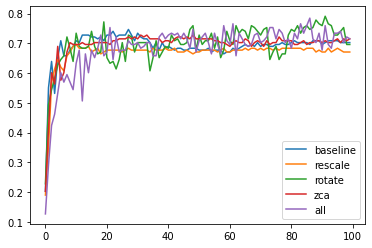

In [13]:
gens = [baselineDataGen, rescaleDataGen, rotateDataGen, zcaDataGen, allDataGen]
labels = ["baseline","rescale","rotate","zca","all"]
generators_historys = compared_generators(gens,labels)
json.dump(generators_historys[0].history,open("./historys/compared_generators_default",'w'))
json.dump(generators_historys[1].history,open("./historys/compared_generators_rescale",'w'))
json.dump(generators_historys[2].history,open("./historys/compared_generators_rotate",'w'))
json.dump(generators_historys[3].history,open("./historys/compared_generators_zca",'w'))
json.dump(generators_historys[4].history,open("./historys/compared_generators_all",'w'))

In [ ]:
#all_loss_history = pd.DataFrame(all_history.history)
#all_loss_history[['accuracy','val_accuracy']].plot()
#all_loss_history[['loss','val_loss']].plot()

https://stackoverflow.com/questions/51748514/does-imagedatagenerator-add-more-images-to-my-dataset <br />
Further, I think it's worth clarifying the meaning of "augmentation" in this context: basically we are augmenting the images when we use ImageDataGenerator and enabling its augmentation capabilities. But the word "augmentation" here does not mean, say, if we have 100 original training images we end up having 1000 images per epoch after augmentation (i.e. the number of training images does not increase per epoch). Instead, it means we use a different transformation of each image in each epoch; hence, if we train our model for, say, 5 epochs, we have used 5 different versions of each original image in training (or 100 * 5 = 500 different images in the whole training, instead of using just the 100 original images in the whole training). To put it differently, the total number of unique images increases in the whole training from start to finish, and not per epoch.

use image generator to preprocess the images can improve the fitting ability of the model, and we now will try to modify the model structure to improve the generalization ability, that is using dropout, batch normalization, and weight decay to improve the accuracy.

<h2> define function to create model and compare the accuracy of different combination of decay_rate, decay_step,and initial rate

In [13]:
def build_model_with_decay(initial_rate,decay_step, decay_rate):
    model = Sequential()

    model.add(Conv2D(filters=64,kernel_size=(3,3),padding='same',input_shape=image_shape,activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))

    model.add(Conv2D(filters=128,kernel_size=(3,3),padding='same',input_shape=image_shape,activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    
    model.add(Conv2D(filters=256,kernel_size=(3,3),padding='same',input_shape=image_shape,activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))

    model.add(Flatten())

    model.add(Dense(256,activation='relu'))

    model.add(Dense(128,activation='relu'))

    model.add(Dense(ClassNum,activation='softmax'))
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_rate,
    decay_steps=decay_step,
    decay_rate=decay_rate,
    staircase=True)


    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr_schedule), metrics=['accuracy'])

    return model

In [14]:
def compared_decay_rate():
    initials = [0.001,0.0001]
    steps = [10000,100000]
    rates = [0.96]
    historys =[]
    for initial in initials:
        for step in steps:
            for rate in rates:
                train, test, val = generateDataFromDirectory(allDataGen)
                model = build_model_with_decay(initial, step, rate)
                history = model.fit(train, epochs=100, validation_data=val)
                historys.append(history)
                loss_history = pd.DataFrame(history.history)
                plt.plot(loss_history['val_accuracy'],label="initial: "+str(initial)+ " steps: "+str(step)+ " rate: "+str(rate))
    plt.legend()
    plt.show()
    plt.savefig("compared_decay_rate_"+time.strftime("%Y%m%d-%H%M%S")+".png")
    return historys
                

Found 543 images belonging to 20 classes.
Found 71 images belonging to 20 classes.
Found 158 images belonging to 20 classes.
Epoch 1/100
37/37 [==============================] - 13s 282ms/step - loss: 3.3754 - accuracy: 0.0847 - val_loss: 2.6593 - val_accuracy: 0.1392
Epoch 2/100
37/37 [==============================] - 10s 267ms/step - loss: 2.5038 - accuracy: 0.1768 - val_loss: 2.2713 - val_accuracy: 0.2025
Epoch 3/100
37/37 [==============================] - 10s 267ms/step - loss: 2.2808 - accuracy: 0.2284 - val_loss: 2.2344 - val_accuracy: 0.2468
Epoch 4/100
37/37 [==============================] - 10s 267ms/step - loss: 2.0661 - accuracy: 0.2947 - val_loss: 1.9121 - val_accuracy: 0.3228
Epoch 5/100
37/37 [==============================] - 10s 268ms/step - loss: 1.7144 - accuracy: 0.3389 - val_loss: 1.9040 - val_accuracy: 0.3481
Epoch 6/100
37/37 [==============================] - 10s 268ms/step - loss: 1.5633 - accuracy: 0.4475 - val_loss: 1.4868 - val_accuracy: 0.4557
Epoch 7/100

Epoch 57/100
37/37 [==============================] - 10s 269ms/step - loss: 0.2885 - accuracy: 0.9024 - val_loss: 1.5834 - val_accuracy: 0.7025
Epoch 58/100
37/37 [==============================] - 10s 267ms/step - loss: 0.2762 - accuracy: 0.9024 - val_loss: 1.2570 - val_accuracy: 0.6962
Epoch 59/100
37/37 [==============================] - 10s 268ms/step - loss: 0.1448 - accuracy: 0.9448 - val_loss: 1.2392 - val_accuracy: 0.7278
Epoch 60/100
37/37 [==============================] - 10s 267ms/step - loss: 0.1810 - accuracy: 0.9355 - val_loss: 1.4943 - val_accuracy: 0.7215
Epoch 61/100
37/37 [==============================] - 10s 269ms/step - loss: 0.3015 - accuracy: 0.9024 - val_loss: 1.5045 - val_accuracy: 0.6835
Epoch 62/100
37/37 [==============================] - 10s 267ms/step - loss: 0.2486 - accuracy: 0.9153 - val_loss: 1.6530 - val_accuracy: 0.6646
Epoch 63/100
37/37 [==============================] - 10s 268ms/step - loss: 0.2978 - accuracy: 0.9024 - val_loss: 1.3414 - val_ac

Epoch 13/100
37/37 [==============================] - 10s 268ms/step - loss: 0.8460 - accuracy: 0.6814 - val_loss: 1.5180 - val_accuracy: 0.5253
Epoch 14/100
37/37 [==============================] - 10s 267ms/step - loss: 1.0112 - accuracy: 0.6206 - val_loss: 1.2641 - val_accuracy: 0.6139
Epoch 15/100
37/37 [==============================] - 10s 268ms/step - loss: 0.8093 - accuracy: 0.7164 - val_loss: 1.2292 - val_accuracy: 0.5823
Epoch 16/100
37/37 [==============================] - 10s 268ms/step - loss: 0.7874 - accuracy: 0.7053 - val_loss: 1.1916 - val_accuracy: 0.6203
Epoch 17/100
37/37 [==============================] - 10s 268ms/step - loss: 0.8122 - accuracy: 0.6980 - val_loss: 1.1478 - val_accuracy: 0.6013
Epoch 18/100
37/37 [==============================] - 10s 268ms/step - loss: 0.7344 - accuracy: 0.7238 - val_loss: 1.0266 - val_accuracy: 0.6646
Epoch 19/100
37/37 [==============================] - 10s 268ms/step - loss: 0.7156 - accuracy: 0.7311 - val_loss: 1.2063 - val_ac

37/37 [==============================] - 10s 268ms/step - loss: 0.4470 - accuracy: 0.8343 - val_loss: 0.9836 - val_accuracy: 0.7342
Epoch 25/100
37/37 [==============================] - 10s 265ms/step - loss: 0.4056 - accuracy: 0.8527 - val_loss: 1.1173 - val_accuracy: 0.6772
Epoch 26/100
37/37 [==============================] - 10s 268ms/step - loss: 0.3773 - accuracy: 0.8785 - val_loss: 1.0605 - val_accuracy: 0.7405
Epoch 27/100
37/37 [==============================] - 10s 269ms/step - loss: 0.3878 - accuracy: 0.8674 - val_loss: 1.0288 - val_accuracy: 0.7152
Epoch 28/100
37/37 [==============================] - 10s 266ms/step - loss: 0.3721 - accuracy: 0.8619 - val_loss: 1.2248 - val_accuracy: 0.6962
Epoch 29/100
37/37 [==============================] - 10s 270ms/step - loss: 0.3643 - accuracy: 0.8564 - val_loss: 1.1764 - val_accuracy: 0.6709
Epoch 30/100
37/37 [==============================] - 10s 268ms/step - loss: 0.3772 - accuracy: 0.8711 - val_loss: 1.0541 - val_accuracy: 0.683

Epoch 36/100
37/37 [==============================] - 10s 268ms/step - loss: 0.2174 - accuracy: 0.9227 - val_loss: 1.2506 - val_accuracy: 0.7089
Epoch 37/100
37/37 [==============================] - 10s 266ms/step - loss: 0.2997 - accuracy: 0.8987 - val_loss: 1.2025 - val_accuracy: 0.6456
Epoch 38/100
37/37 [==============================] - 10s 268ms/step - loss: 0.2986 - accuracy: 0.8674 - val_loss: 1.0827 - val_accuracy: 0.7215
Epoch 39/100
37/37 [==============================] - 10s 268ms/step - loss: 0.3009 - accuracy: 0.8803 - val_loss: 1.1155 - val_accuracy: 0.7215
Epoch 40/100
37/37 [==============================] - 10s 268ms/step - loss: 0.3175 - accuracy: 0.9042 - val_loss: 1.2121 - val_accuracy: 0.6835
Epoch 41/100
37/37 [==============================] - 10s 269ms/step - loss: 0.2516 - accuracy: 0.9171 - val_loss: 1.0538 - val_accuracy: 0.7532
Epoch 42/100
37/37 [==============================] - 10s 269ms/step - loss: 0.2222 - accuracy: 0.9227 - val_loss: 1.2128 - val_ac

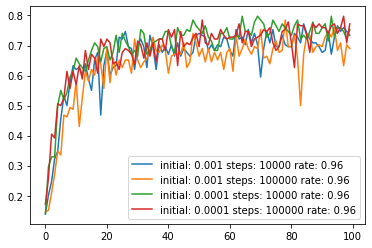

<Figure size 432x288 with 0 Axes>

In [15]:
decay_historys = compared_decay_rate()

In [ ]:
json.dump(decay_historys[0].history,open("./historys/compared_decay",'w'))
json.dump(generators_historys[1].history,open("./historys/compared_generators_rescale",'w'))
json.dump(generators_historys[2].history,open("./historys/compared_generators_rotate",'w'))
json.dump(generators_historys[3].history,open("./historys/compared_generators_zca",'w'))
json.dump(generators_historys[4].history,open("./historys/compared_generators_all",'w'))

<h2> define function to compare accuracy between model using decay and reduction </h2>

In [18]:
def compared_reduction_decay():
    train, test, val = generateDataFromDirectory(allDataGen)
    reduction_model = build_baseline()
    decay_model = build_model_with_decay(0.0001,10000,0.96)
    #combined_model = build_model_with_decay(0.001,10000,0.96)
    reduction_history = reduction_model.fit(train, epochs=20,validation_data=val,callbacks=callback_list_with_reduction)
    decay_history = decay_model.fit(train, epochs=10,validation_data=val,callbacks=callback_list)
    #combined_history = combined_model.fit(train, epochs=10,validation_data=val,callbacks=callback_list_with_reduction)
                
    historys = [reduction_history, decay_history]
    reduction_loss_history = pd.DataFrame(reduction_history.history)
    decay_loss_history = pd.DataFrame(decay_history.history)
    #combined_loss_history = pd.DataFrame(combined_history.history)
    plt.plot(reduction_loss_history['val_accuracy'],label="reduction")
    plt.plot(decay_loss_history['val_accuracy'],label="decay")
    #plt.plot(combined_loss_history['val_accuracy'],label="combined")
    plt.legend()
    plt.savefig("compared_reduction_rate_"+time.strftime("%Y%m%d-%H%M%S")+".png")
    plt.show()
    return historys

Found 132 images belonging to 7 classes.
Found 31 images belonging to 7 classes.
Found 34 images belonging to 7 classes.
Epoch 1/20
9/9 [==============================] - ETA: 0s - loss: 15.7183 - accuracy: 0.1212
Epoch 00001: val_accuracy did not improve from 0.70588
9/9 [==============================] - 27s 3s/step - loss: 15.7183 - accuracy: 0.1212 - val_loss: 1.8250 - val_accuracy: 0.2941 - lr: 0.0010
Epoch 2/20
9/9 [==============================] - ETA: 0s - loss: 1.6421 - accuracy: 0.3939
Epoch 00002: val_accuracy did not improve from 0.70588
9/9 [==============================] - 24s 3s/step - loss: 1.6421 - accuracy: 0.3939 - val_loss: 1.5315 - val_accuracy: 0.3824 - lr: 0.0010
Epoch 3/20
9/9 [==============================] - ETA: 0s - loss: 1.2716 - accuracy: 0.5000
Epoch 00003: val_accuracy did not improve from 0.70588
9/9 [==============================] - 21s 2s/step - loss: 1.2716 - accuracy: 0.5000 - val_loss: 1.5634 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/20
9/9 [

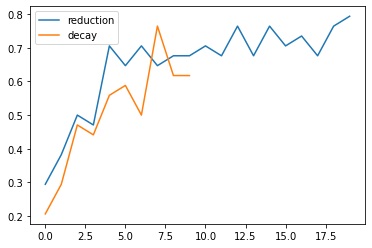

In [19]:
compared_reduction_decay()

# building the final model and evaluate it

In [13]:
os.system("mkdir saved_models")
filepath = "saved_models/weight-model-improvement-{epoch:02d}-{val_accuracy:.2f}-"+time.strftime("%Y%m%d-%H%M%S")+".h5"
checkpoint = ModelCheckpoint(filepath, monitor="val_accuracy",verbose=1,save_best_only=True, model="max", save_weights_only=False)
earlystopping = EarlyStopping(monitor="val_loss",patience=15,verbose=1,restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=10, verbose=0,
    mode='auto', min_delta=0.0001, cooldown=0, min_lr=0,
)
log_csv = CSVLogger("my_logs.csv",separator=',', append=False)
callback_list = [checkpoint,earlystopping,log_csv]
callback_list_with_reduction = [checkpoint,earlystopping,log_csv,reduce_lr]

In [17]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, Activation, BatchNormalization, Lambda
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam


def build_final_model():
    model = Sequential()

    model.add(Conv2D(filters=64,kernel_size=(3,3),padding='same',input_shape=image_shape,activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Conv2D(filters=128,kernel_size=(3,3),padding='same',input_shape=image_shape,activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(rate=0.25))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=128,kernel_size=(3,3),padding='same',input_shape=image_shape,activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Conv2D(filters=128,kernel_size=(3,3),padding='same',input_shape=image_shape,activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(rate=0.25))
    model.add(BatchNormalization())


    model.add(Flatten())

    model.add(Dense(1024,activation='relu'))

    model.add(Dropout(rate=0.25))

    model.add(Dense(512,activation='relu'))

    model.add(Dense(30,activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

    return model

In [ ]:
train, test, val = generateDataFromDirectory(allDataGen)
reduction_model = build_final_model()
reduction_history = reduction_model.fit(train, epochs=100,validation_data=val,callbacks=callback_list_with_reduction)
reduction_loss_history = pd.DataFrame(reduction_history.history)

plt.legend()
plt.savefig("final_model"+time.strftime("%Y%m%d-%H%M%S")+".png")
plt.show()

Found 977 images belonging to 30 classes.
Found 172 images belonging to 30 classes.
Found 360 images belonging to 30 classes.
Epoch 1/100
 4/10 [===========>..................] - ETA: 7s - loss: 4.3522 - accuracy: 0.0925

<AxesSubplot:>

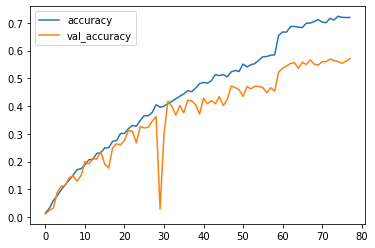

In [49]:
reduction_loss_history[["accuracy","val_accuracy"]].plot()